# Analysis
This notebook compiles all the analysis done on the ExTRI2 resource, separated by the section of the paper it is commented on.

The "External notebook" section compiles all external notebooks from where information is obtained, not present in this notebook.

In [325]:
__import__('sys').path.append('../scripts/common/'); __import__('notebook_utils').table_of_contents('analysis.ipynb')

<h3>Table of contents</h3>


[Analysis](#Analysis)
- [Setup & configuration](#Setup-&-configuration)
- [2.2. Pipeline Results](#2.2.-Pipeline-Results)
- [The ExTRI2 resource - OLD](#The-ExTRI2-resource---OLD)
- [2.3.2. Validation Outcomes + 3.4. Validation Criteria and Process](#2.3.2.-Validation-Outcomes-+-3.4.-Validation-Criteria-and-Process)
  - [MUST CORRECT](#MUST-CORRECT)
- [3.2. Curated Dataset for Training - The NTNU collection](#3.2.-Curated-Dataset-for-Training---The-NTNU-collection)
- [Other notebooks](#Other-notebooks)
  - [3.1. Data Sources & Preparation](#3.1.-Data-Sources-&-Preparation)
  - [3.3. Classifiers dataset improvement](#3.3.-Classifiers-dataset-improvement)

## Setup & configuration

In [2]:
# IMPORTS
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import upsetplot
import warnings
from analysis import *


from Bio import Entrez
# *Always* tell NCBI who you are
Entrez.email = "example24@gmail.com"

## Custom functions
import sys

sys.path.append('../scripts/common/')
from notebook_utils import table_of_contents, table_from_dict, h3, h4, h5, md
from analysis import load_config, retrieve_annotations_entrez
pd.set_option('display.max_colwidth', 20)

In [3]:
# UNCOMMENT TO REIMPORT A CERTAIN FUNCTION AFTER MODIFYING ITS CODE
import importlib 
import analysis
importlib.reload(analysis)
from analysis import *

In [4]:
# LOAD & PREPROCESSING
config = load_config()

# Load ExTRI dataset
ExTRI2_df = pd.read_csv(config['final_ExTRI2_p'], sep="\t", dtype=str, keep_default_na=False)
ExTRI2_df['TRI Id']             = ExTRI2_df['TF Id'] + '|' + ExTRI2_df['TG Id']

# LOAD VALIDATION DATASET
# Load the validation dataset
validated_df           = pd.read_csv(config['final_validated_p'], sep='\t', header=0, dtype=str)


## 2.2. Pipeline Results

In [317]:
def split_in_dbTF_coTF_ll_coTF(ExTRI2_df):
    m_dbTF = ExTRI2_df['TF_type'].str.contains('dbTF')
    m_coTF = ExTRI2_df['TF_type'].apply(lambda x: 'coTF' in set(x.split(';'))) & ~m_dbTF
    m_ll_coTF = ExTRI2_df['TF_type'].str.contains('ll_coTF') & ~m_dbTF & ~m_coTF

    dbTF_df = ExTRI2_df[m_dbTF]
    coTF_df = ExTRI2_df[m_coTF]
    ll_coTF_df = ExTRI2_df[m_ll_coTF]

    return dbTF_df, coTF_df, ll_coTF_df    

dbTF_df, coTF_df, ll_coTF_df = split_in_dbTF_coTF_ll_coTF(ExTRI2_df)

In [319]:
# TABLES 1, 2
def table_1(ExTRI2_df, dbTF_df, coTF_df, ll_coTF_df) -> dict:

    h3("Table 1")

    analysis_dfs = []
    for df, name in [(ExTRI2_df, 'Total'), (dbTF_df, 'dbTF'), (coTF_df, 'coTF'), (ll_coTF_df, 'll_coTF')]:

        analytics = {}
        analytics['TRI-sentences'] = f"{len(df):,}"

        for mor in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
            analytics[mor] = f"{len(df[df['MoR'] == mor]):,} ({len(df[df['MoR'] == mor])/len(df):.2%})"
        
        analytics['TG is not normalized'] = f"{(df['TG Id'].isna()).sum():,} ({(df['TG Id'].isna()).sum() / len(df):.2%})"
        analytics['TF is mutated'] = f"{(df['Mutated_TF'] == 'True').sum():,} ({(df['Mutated_TF'] == 'True').sum() / len(df):.2%})"
        analytics['Unique TRIs'] = f"{df['TRI Id'].nunique():,}"

        for T in ['TF', 'TG']:
            analytics[f'Unique {T} IDs'] = f"{df[f'{T} Id'].nunique():,}"
            analytics[f'Unique human {T} IDs'] = f"{df[df[f'{T} TaxID'] == '9606'][f'{T} Id'].nunique():,}"

        # Convert the analytics dictionary to a DataFrame and add it to the list
        analysis_df = pd.DataFrame.from_dict(analytics, orient='index', columns=[name])
        analysis_dfs.append(analysis_df)

    display(pd.concat(analysis_dfs, axis=1))
    return 

def table_2(final_df, dbTF_df):

    # Obtained from other sources
    all_pmids = 38_776_000
    has_gene_entities = 6_507_211

    # Get the number of PMIDs in candidate sentences
    candidate_sents = pd.read_csv(config['raw_ExTRI2_p'], sep='\t', header=1, chunksize=1_000_000, keep_default_na=False)
    candidate_PMIDs = set()
    for chunk in candidate_sents:
        PMIDs = chunk['#SentenceID'].apply(lambda row: row.split(':')[1])
        candidate_PMIDs.update(PMIDs)

    has_TRIs = final_df['PMID'].nunique()
    has_dbTF_TRIs = dbTF_df['PMID'].nunique()

    h3("Table 2")
    analytics = {}
    analytics['All PMIDs'] = f"{all_pmids:,}"
    analytics['Has gene entities'] = f"{has_gene_entities:,} ({has_gene_entities / all_pmids:.2%})"
    analytics['Has candidate sentences'] = f"{len(candidate_PMIDs):,} ({len(candidate_PMIDs) / all_pmids:.2%})"
    analytics['Has TRIs'] = f"{has_TRIs:,} ({has_TRIs / all_pmids:.2%})"
    analytics['Has dbTF TRIs'] = f"{has_dbTF_TRIs:,} ({has_dbTF_TRIs / all_pmids:.2%})"


    analysis_df = pd.DataFrame.from_dict(analytics, orient='index', columns=['Num sentences'])
    # analysis_df.to_excel('tables_figs/table_1.xlsx')
    display(analysis_df)

    return 

table_1(ExTRI2_df, dbTF_df, coTF_df, ll_coTF_df)
table_2(ExTRI2_df, dbTF_df)

<h3>Table 1</h3>

,Total,dbTF,coTF,ll_coTF
TRI-sentences,"836,024","433,146","185,503","217,375"
UNDEFINED,"244,032 (29.19%)","140,063 (32.34%)","55,453 (29.89%)","48,516 (22.32%)"
ACTIVATION,"416,370 (49.80%)","210,977 (48.71%)","77,724 (41.90%)","127,669 (58.73%)"
REPRESSION,"175,622 (21.01%)","82,106 (18.96%)","52,326 (28.21%)","41,190 (18.95%)"
TG is not normalized,0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%)
TF is mutated,"2,755 (0.33%)","1,336 (0.31%)",865 (0.47%),554 (0.25%)
Unique TRIs,"284,724","143,651","83,280","57,793"
Unique TF IDs,"7,180","3,453","3,078",649
Unique human TF IDs,"2,758","1,280","1,322",156
Unique TG IDs,"25,805","20,609","14,643","13,199"


<h3>Table 2</h3>

,Num sentences
All PMIDs,"38,776,000"
Has gene entities,"6,507,211 (16.78%)"
Has candidate sentences,"1,618,959 (4.18%)"
Has TRIs,"293,108 (0.76%)"
Has dbTF TRIs,"161,906 (0.42%)"


<h3>Figure 2</h3>

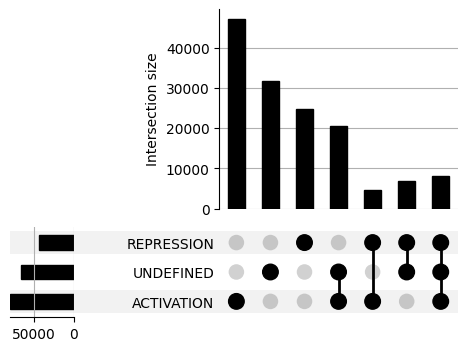

<h3>Table S6</h3>

,Counts
ACTIVATION,"47,148 (32.82%)"
REPRESSION,"24,763 (17.24%)"
UNDEFINED,"31,691 (22.06%)"
"ACTIVATION,REPRESSION","4,613 (3.21%)"
"ACTIVATION,UNDEFINED","20,593 (14.34%)"
"REPRESSION,UNDEFINED","6,735 (4.69%)"
"ACTIVATION,REPRESSION,UNDEFINED","8,108 (5.64%)"
1 MoR,"103,602 (72.12%)"
2 MoR,"31,941 (22.24%)"
3 MoR,"8,108 (5.64%)"


In [320]:
# FIGURE 2 & TABLE S6
def figure_2(df):
    # 1. Get the sets of TRIs for each MoR

    # Create a set of TRIs for each MoR
    A_set = set(df[df["MoR"] == 'ACTIVATION']['TRI Id'])
    R_set = set(df[df["MoR"] == 'REPRESSION']['TRI Id'])
    U_set = set(df[df["MoR"] == 'UNDEFINED']['TRI Id'])
    # 2. Get the union of these sets
    MoR_listoflists = [
        ['ACTIVATION'], ['REPRESSION'], ['UNDEFINED'],
        ['ACTIVATION', 'REPRESSION'],
        ['ACTIVATION', 'UNDEFINED'],
        ['REPRESSION', 'UNDEFINED'],
        ['ACTIVATION', 'REPRESSION', 'UNDEFINED']
    ]
    MoR_counts = [
        len(A_set - R_set - U_set), 
        len(R_set - A_set - U_set), 
        len(U_set - R_set - A_set),
        len((A_set & R_set) - U_set),
        len((A_set & U_set) - R_set),
        len((U_set & R_set) - A_set),
        len(A_set & R_set & U_set),    
    ]

    # Ignore warnings for upsetplot: it has a lot (library seems like is not updated)
    warnings.filterwarnings('ignore')
    example = upsetplot.from_memberships(MoR_listoflists, data=MoR_counts)
    upsetplot.plot(example)  # doctest: +SKIP
    h3("Figure 2")
    # plt.title("")
    plt.show()
    warnings.filterwarnings('default')

    return MoR_counts, MoR_listoflists

def table_S6(MoR_counts, MoR_listoflists):
    h3("Table S6")
    MoR_counts_table = {}
    for label, count in zip(MoR_listoflists, MoR_counts):
        MoR_counts_table[",".join(label)] = count

    MoR_counts_table['1 MoR'] = sum([MoR_counts_table[MoR] for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']])
    MoR_counts_table['2 MoR'] = sum([MoR_counts_table[MoR] for MoR in ['ACTIVATION,REPRESSION', 'ACTIVATION,UNDEFINED', 'REPRESSION,UNDEFINED']])
    MoR_counts_table['3 MoR'] = MoR_counts_table['ACTIVATION,REPRESSION,UNDEFINED']
    TOTAL = sum([MoR_counts_table[f'{n} MoR'] for n in range(1, 4)])

    for key, value in MoR_counts_table.items():
        MoR_counts_table[key] = f"{value:,} ({value / TOTAL:.2%})"

    display(pd.DataFrame.from_dict(MoR_counts_table, orient='index', columns=['Counts']))

MoR_counts, MoR_listoflists = figure_2(dbTF_df)
table_S6(MoR_counts, MoR_listoflists)

24402 (0.03) sentences are discarded as their TF/TG is mapped to +1 ID
There are 85 human genes in ExTRI2 that are not found in the all_human_genes df.
They appear in 406 rows, which will be discarded


Number of genes retrieved by category, considering direct human, and mouse/rat orthologs

,human,orthologs,unique,orth.unique,% uniq.,% orth.uniq.
Total,283636,429303,10100,14248,5.3%,10.7%
PROTEIN_CODING,273892,371481,9108,9902,44.2%,48.1%
ncRNA,8108,9975,814,820,3.7%,3.7%
PSEUDO,816,875,107,117,0.6%,0.7%
OTHER,700,610,36,31,4.3%,3.7%
snoRNA,21,25,11,13,0.9%,1.1%
tRNA,43,43,8,8,1.2%,1.2%
snRNA,31,31,7,7,4.2%,4.2%
BIOLOGICAL_REGION,14,0,6,0,0.0%,0.0%
rRNA,1,1,1,1,0.1%,0.1%


<span style='color:red'>There are 3 dbTFs that are non protein-coding. Should we remove them??</span>

,NCBI GeneID,Symbol,Gene Type,Taxonomic Name,Description
8461,100859930,HEIH,ncRNA,Homo sapiens,hepatocellular c...
11907,100288711,DUX4L9,PSEUDO,Homo sapiens,double homeobox ...
17113,58160,NFE4,ncRNA,Homo sapiens,"nuclear factor, ..."


Number of retrieved human dbTFs

,unique,%
all considered,1839,100.0%
human,1271,69.1%
orthologs,1683,91.5%


<h3>Figure 3</h3>

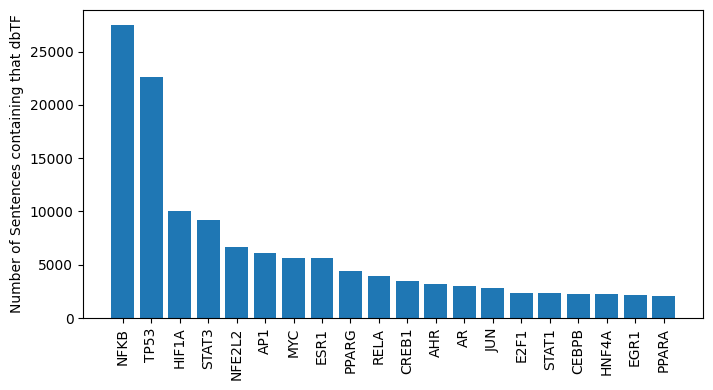

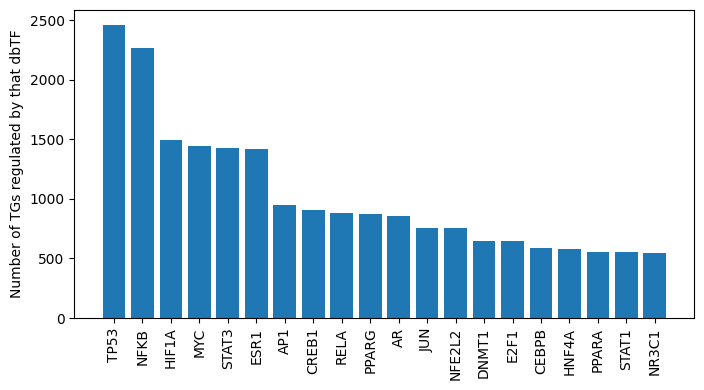

In [321]:
def load_all_human_genes():
    # Load all human TGs
    # downloaded from: https://www.ncbi.nlm.nih.gov/datasets/gene/taxon/9606/
    all_human_genes = pd.read_csv(config['all_human_TGs_p'], sep='\t', header=0, dtype=str)
    all_human_genes = all_human_genes[['NCBI GeneID', 'Symbol', 'Gene Type', 'Taxonomic Name', 'Description']]
    all_human_genes.loc[all_human_genes['Gene Type'].isna(), 'Gene Type'] = 'nan'

    # Add AP1 and NFKB complexes
    all_human_genes = pd.concat([all_human_genes, pd.DataFrame({
        'NCBI GeneID': ['Complex:AP1', 'Complex:NFKB'], 
        'Symbol': ['AP1', 'NFKB'],
        'Description': ['', ''],
        'Taxonomic Name': ['Homo sapiens', 'Homo sapiens'],
        'Gene Type': ['PROTEIN_CODING', 'PROTEIN_CODING'],
        })], ignore_index=True)
    
    # Ensure the data is expected: all human, no duplicate IDs
    assert all_human_genes['Taxonomic Name'].nunique() == 1
    assert all_human_genes['Taxonomic Name'].unique()[0] == 'Homo sapiens'
    assert (all_human_genes['NCBI GeneID'].duplicated()).sum() == 0 

    return all_human_genes

def display_TG_distribution(human_dbTF_df: pd.DataFrame, dbTF_df: pd.DataFrame, all_human_genes: pd.DataFrame) -> None:
    '''Display how many TGs we have retrieved'''

    # Initialise dict    
    TG_types = {}
    TG_types['Total'] = {
        'human': len(human_dbTF_df),
        'orthologs': len(dbTF_df),
        'unique': len(human_dbTF_df['TG Id'].unique()),
        'orth.unique': len(dbTF_df['TG_human_entrez_gene'].unique()),
        '% uniq.': f"{len(human_dbTF_df['TG Id'].unique()) / len(all_human_genes):.1%}",
        '% orth.uniq.': f"{len(dbTF_df['TG Id'].unique()) / len(all_human_genes):.1%}"
    }

    # Fill in dict
    for gene_type in all_human_genes['Gene Type'].unique():
        human_genes_of_gene_type = all_human_genes[all_human_genes['Gene Type'] == gene_type]['NCBI GeneID']

        human_sents = human_dbTF_df[human_dbTF_df['TG Id'].isin(human_genes_of_gene_type)]
        ortholog_sents = dbTF_df[dbTF_df['TG_human_entrez_gene'].isin(human_genes_of_gene_type)]
        TG_types[gene_type] = {
            'human': len(human_sents),
            'orthologs': len(ortholog_sents),
            'unique': len(human_sents['TG Id'].unique()),
            'orth.unique': len(ortholog_sents['TG_human_entrez_gene'].unique()),
        }
        TG_types[gene_type]['% uniq.']      = f"{TG_types[gene_type]['unique'] / len(human_genes_of_gene_type):.1%}"
        TG_types[gene_type]['% orth.uniq.'] = f"{TG_types[gene_type]['orth.unique'] / len(human_genes_of_gene_type):.1%}"


    # Convert to dataframe & display
    md("Number of genes retrieved by category, considering direct human, and mouse/rat orthologs")
    display(pd.DataFrame.from_dict(TG_types, orient='index').sort_values(by='unique', ascending=False))

def display_TF_distribution(human_dbTF_df, dbTF_df, all_human_genes, ):

    # Check if all dbTFs are protein-coding
    retrieved_TF_IDs = set(human_dbTF_df['TF Id'])
    assert retrieved_TF_IDs - set(all_human_genes['NCBI GeneID']) == set(), "Some dbTFs are not part of the NCBI df"

    # TODO - Fix. Makes no sense non-protein-coding genes can be TFs. 
    #       1. Check where do they come from. TFCheckpoint? (I have to check this anyways)
    #       2. Ask Astrid whether we should remove them
    md("<span style='color:red'>There are 3 dbTFs that are non protein-coding. Should we remove them??</span>")
    non_protein_coding_dbTFs = retrieved_TF_IDs - set(all_human_genes[all_human_genes['Gene Type'] == 'PROTEIN_CODING']['NCBI GeneID'])
    display(all_human_genes[all_human_genes['NCBI GeneID'].isin(non_protein_coding_dbTFs)])

    # Get set of human dbTFs
    with open(config['dbTFs_p'], 'r') as f:
        dbTFs_set = {l.strip('\n') for l in f}
    human_dbTFs_set = dbTFs_set.intersection(set(all_human_genes['NCBI GeneID'])) 

    dbTF_retrieval_t = {
        'all considered': len(human_dbTFs_set),
        'human': len(human_dbTF_df['TF Id'].unique()),
        'orthologs': len(dbTF_df['TF_human_entrez_gene'].unique())
    }
    for k, v in dbTF_retrieval_t.items():
        dbTF_retrieval_t[k] = {
            "unique": v,
            "%": f"{v / len(human_dbTFs_set):.1%}"
        }


    md("Number of retrieved human dbTFs")
    display(pd.DataFrame.from_dict(dbTF_retrieval_t, orient='index'))

def figure_3(human_dbTF_df):
    '''Plot the most common dbTFs'''

    h3("Figure 3")

    # Plot the most common dbTFs
    def plot_counts(df, ylabel):
        counts = df['TF Symbol'].value_counts()
        plt.figure(figsize=(8,4))
        plt.bar(counts[:20].index, counts[:20])
        plt.xticks(rotation='vertical')
        plt.ylabel(ylabel)

    plot_counts(human_dbTF_df, "Number of Sentences containing that dbTF")
    unique_TRIs = human_dbTF_df.drop_duplicates(subset='TRI Id', keep='first')
    plot_counts(unique_TRIs, "Number of TGs regulated by that dbTF")
    plt.show()    

def human_TF_TG_analysis(ExTRI2_df):
    '''Check the category of the found TGs'''

    # Load dataframe of all human genes
    all_human_genes = load_all_human_genes()

    # Show how many sentences have multiple mappings
    multiple_mapped = ((ExTRI2_df['TF Id'].str.contains(';')) | (ExTRI2_df['TG Id'].str.contains(';'))).sum()
    print(f"{multiple_mapped} ({multiple_mapped / len(ExTRI2_df):.2f}) sentences are discarded as their TF/TG is mapped to +1 ID")

    # Filter ExTRI2 by only those containing human dbTFs (ignore those mapped to +1 ids)
    dbTF_df = ExTRI2_df[ExTRI2_df['TF_type'] == 'dbTF']
    human_dbTF_df = dbTF_df[(dbTF_df['TG TaxID'] == '9606') & (dbTF_df['TF TaxID'] == '9606')] 

    # Discard human TGs that are not found in the NCBI human genes df
    # TODO - Ask Astrid if she thinks this is a good approach. Should we remove from the ExTRI2_df too? If so, I should also do mouse & rat
    m_TG_id = human_dbTF_df['TG Id'].isin(all_human_genes['NCBI GeneID'])
    print(f"There are {len(human_dbTF_df[~m_TG_id]['TG Id'].unique())} human genes in ExTRI2 that are not found in the all_human_genes df.")
    print(f"They appear in {(~m_TG_id).sum()} rows, which will be discarded")
    human_dbTF_df = human_dbTF_df[m_TG_id]

    # Show how many TGs we've obtained
    display_TG_distribution(human_dbTF_df, dbTF_df, all_human_genes)

    # Show how many TFs we've obtained
    display_TF_distribution(human_dbTF_df, dbTF_df, all_human_genes)

    # Plot counts
    figure_3(human_dbTF_df)

    return

human_TF_TG_analysis(ExTRI2_df)

## The ExTRI2 resource - OLD

In [ ]:
# TODO - Remove if it is useless for the article

In [ ]:
def get_analytics(df) -> dict:
    h3("General analytics")
    analytics = {}
    analytics['Num sents']      = len(df)
    analytics['Uniq sent-TRI Id'] = set(df['PMID+Sent+TRI_Id'])
    analytics['Uniq sent-TRI']  = set(df['PMID+Sent+TRI'])
    analytics['Uniq PMIDs']     = set(df['PMID'])
    analytics['Uniq TRI Id']    = set(df['TRI Id'])
    
    analytics['Uniq TF Id']     = set(df['TF Id'])
    analytics['Human TF Id']    = set(df[df['TF TaxID'] == '9606']['TF Id'])
    analytics['Human TF Id 2']  = set(df[df['TF TaxID'].str.contains('9606')]['TF Id'])

    analytics['Uniq TG Id']     = set(df['TG Id'])
    analytics['Human TG Id']    = set(df[df['TG TaxID'] == '9606']['TG Id'])
    analytics['Human TG Id 2']  = set(df[df['TG TaxID'].str.contains('9606')]['TG Id'])

    analytics['Num mutated TF']   = (df['Mutated_TF'] == 'True').sum()

    return analytics

def print_analytics(analytics):
    for key, value in analytics.items():
        if type(value) is set:
            num = len(value)
        else:
            num = value
        print(f"{key:<17}{num:,}")

print_analytics(get_analytics(ExTRI2_df))

<h3>General analytics</h3>

Num sents        836,024
Uniq sent-TRI Id 836,024
Uniq sent-TRI    834,723
Uniq PMIDs       293,108
Uniq TRI Id      284,724
Uniq TF Id       7,180
Human TF Id      2,758
Human TF Id 2    3,477
Uniq TG Id       25,805
Human TG Id      12,372
Human TG Id 2    13,591
Num mutated TF   2,755


In [ ]:
def show_analytics(label, num, total):
    total_len = total if type(total) is int else len(total)
    num_len = num if type(num) in (int, np.int64) else len(num)
    print(f'{label:30}{num_len:,}/{total_len:<10,}{num_len/total_len:>10.2%}')

def display_uniques():
    h3("Unique values")
    m_cols = ['#SentenceID', 'Sentence', 'PMID', 'TRI Id', 'PMID+Sent', 'PMID+Sent+TRI', 'PMID+Sent+TRI_Id', '',
            'Valid', 'MoR', 'TF_type', 'TF TaxID', 'TG TaxID', '',
            'TF', 'TF Id', 'TF Symbol', 'TF_human_entrez_gene', 'TF_hgnc_id', 'TF_human_symbol', '',
            'TG', 'TG Id', 'TG Symbol', 'TG_human_entrez_gene', 'TG_hgnc_id', 'TG_human_symbol', 
            'Mutated Genes', 'Mutated_TF']

    total = len(ExTRI2_df)
    for col in m_cols:
        if col == '':
            print()
            continue
        num = ExTRI2_df[col].unique()
        show_analytics(f'Unique {col}', num, total)

def display_NA_values():
    h3("Columns with Na values")
    cols_to_ignore = ['Mutated Genes', 'Mutation offsets', 'tags']

    total = len(ExTRI2_df)
    for col in ExTRI2_df.columns:
        col_has_na = int(ExTRI2_df[col].isna().sum())
        if col_has_na & (col not in cols_to_ignore):
            show_analytics(f'{col}', col_has_na, total)

def display_cols_with_colons():
    h3("Columns with colons (;)")
    colon_cols = ['TF_type', 'TF TaxID', 'TG TaxID', '',
            'TF', 'TF Id', 'TF Symbol', 'TF_human_entrez_gene', 'TF_hgnc_id', 'TF_human_symbol', '',
            'TG', 'TG Id', 'TG Symbol', 'TG_human_entrez_gene', 'TG_hgnc_id', 'TG_human_symbol', 
            'Mutated Genes']

    total = len(ExTRI2_df)
    for col in colon_cols:
        if col == '':
            print()
            continue
        num = int(ExTRI2_df[col].str.contains(';').sum())
        show_analytics(f'{col}', num, total)


    h3("Number of unique rows with ;")
    for col in colon_cols:
        if col == '':
            print()
            continue
        if ExTRI2_df[col].isna().sum() != 0:
            continue
        m = ExTRI2_df[col].str.contains(';')
        num = ExTRI2_df[m][col].unique()
        num_un = ExTRI2_df[col].unique()
        show_analytics(f'{col}', num, num_un)

def display_TF_types():
    h3("Joined TF Types")
    squished = ExTRI2_df['TF_type'].apply(lambda x: ";".join(set(x.split(';'))))
    print(squished.value_counts())
    print()

def display_unique_content_per_col():
    h3("Columns with <30 unique values")
    for col in ExTRI2_df.columns:
        uniq = ExTRI2_df[col].unique()
        if len(uniq) < 30:
            print(f"{col:25}{len(uniq):<10}{', '.join(uniq.astype(str))}")
        # else:
        #     print(f"{col:25}{len(uniq):<10}{', '.join(uniq[:2])}")


# TODO - Understand why there are Na values in hgnc & entrez_gene columns

display_uniques()
display_NA_values()
display_cols_with_colons()
display_TF_types()
display_unique_content_per_col()

<h3>Unique values</h3>

Unique #SentenceID            836,024/836,024      100.00%
Unique Sentence               834,786/836,024       99.85%
Unique PMID                   293,108/836,024       35.06%
Unique TRI Id                 284,724/836,024       34.06%
Unique PMID+Sent              539,924/836,024       64.58%
Unique PMID+Sent+TRI          834,723/836,024       99.84%
Unique PMID+Sent+TRI_Id       836,024/836,024      100.00%

Unique Valid                  1/836,024        0.00%
Unique MoR                    3/836,024        0.00%
Unique TF_type                78/836,024        0.01%
Unique TF TaxID               20/836,024        0.00%
Unique TG TaxID               22/836,024        0.00%

Unique TF                     24,083/836,024        2.88%
Unique TF Id                  7,180/836,024        0.86%
Unique TF Symbol              6,139/836,024        0.73%
Unique TF_human_entrez_gene   4,792/836,024        0.57%
Unique TF_hgnc_id             4,789/836,024        0.57%
Unique TF_human_symbol        4

<h3>Columns with Na values</h3>

<h3>Columns with colons (;)</h3>

TF_type                       16,562/836,024        1.98%
TF TaxID                      16,562/836,024        1.98%
TG TaxID                      8,131/836,024        0.97%

TF                            68/836,024        0.01%
TF Id                         16,562/836,024        1.98%
TF Symbol                     16,562/836,024        1.98%
TF_human_entrez_gene          105,310/836,024       12.60%
TF_hgnc_id                    105,257/836,024       12.59%
TF_human_symbol               105,257/836,024       12.59%

TG                            8/836,024        0.00%
TG Id                         8,131/836,024        0.97%
TG Symbol                     8,131/836,024        0.97%
TG_human_entrez_gene          87,741/836,024       10.50%
TG_hgnc_id                    87,705/836,024       10.49%
TG_human_symbol               87,705/836,024       10.49%
Mutated Genes                 1,760/836,024        0.21%


<h3>Number of unique rows with ;</h3>

TF_type                       75/78            96.15%
TF TaxID                      17/20            85.00%
TG TaxID                      19/22            86.36%

TF                            42/24,083         0.17%
TF Id                         1,200/7,180         16.71%
TF Symbol                     1,141/6,139         18.59%
TF_human_entrez_gene          1,924/4,792         40.15%
TF_hgnc_id                    1,921/4,789         40.11%
TF_human_symbol               1,921/4,789         40.11%

TG                            8/55,571         0.01%
TG Id                         1,965/25,805         7.61%
TG Symbol                     1,902/22,904         8.30%
TG_human_entrez_gene          4,636/17,525        26.45%
TG_hgnc_id                    4,631/17,521        26.43%
TG_human_symbol               4,631/17,522        26.43%
Mutated Genes                 778/2,005         38.80%


<h3>Joined TF Types</h3>

TF_type
dbTF            432325
ll_coTF         216298
coTF            184766
-;ll_coTF         1077
-;coTF             731
coTF;dbTF          547
-;dbTF             254
-;coTF;dbTF         13
ll_coTF;dbTF         7
ll_coTF;coTF         6
Name: count, dtype: int64



<h3>Columns with <30 unique values</h3>

Valid                    1         Valid
MoR                      3         UNDEFINED, ACTIVATION, REPRESSION
Mutated_TF               2         False, True
TF TaxID                 20        9606, 10090, 10116, 9606;9606, 10090;10090, 9606;9606;9606, 10116;10116, 9606;9606;9606;9606, 10090;10090;10090, 10116;10116;10116, 9606;9606;9606;9606;9606;9606, 10090;10090;10090;10090, 10116;10116;10116;10116, 9606;9606;9606;9606;9606;9606;9606;9606, 9606;9606;9606;9606;9606, 10090;10090;10090;10090;10090;10090;10090, 10090;10090;10090;10090;10090;10090, 10090;10090;10090;10090;10090, 9606;9606;9606;9606;9606;9606;9606, 9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606
TG TaxID                 22        9606, 9606;9606, 10090, 10116, 10090;10090, 9606;9606;9606, 10116;10116;10116, 10116;10116, 10090;10090;10090, 9606;9606;9606;9606, 10090;10090;10090;10090;10090, 9606;9606;9606;9606;9606;9606, 10090;10090;10090;10090, 10116;10116;10116;10116, 9606;9606;9606;9606;96

In [ ]:
analysis = {
    'TOTAL': [],
    'UNDEFINED': [],
    'ACTIVATION': [],
    'REPRESSION': [],
    'Uniq. TRIs': [],
    'TRI maps to 1 MoR': [],
    'TRI maps to 2 MoR': [],
    'TRI maps to 3 MoR': []
}
mask = ExTRI2_df['Mutated_TF'] == 'True'
TRI_mutated    = ExTRI2_df[mask]
TRI_nonmutated = ExTRI2_df[~mask]
for df in (ExTRI2_df, TRI_nonmutated, TRI_mutated):
    analysis['TOTAL'].append(len(df))
    for mor in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
        analysis[mor].append(f"{len(df[df['MoR'] == mor])} ({len(df[df['MoR'] == mor])/len(df):.2%})")
    analysis['Uniq. TRIs'].append(df['TRI Id'].nunique())

    # Analyse whether TRIs get assigned more than 1 MoR.
    grouped = df.groupby('TRI Id')['MoR'].nunique()
    analysis['TRI maps to 1 MoR'].append((grouped == 1).sum())
    analysis['TRI maps to 2 MoR'].append((grouped == 2).sum())
    analysis['TRI maps to 3 MoR'].append((grouped == 3).sum())
    
    
analysis_df = pd.DataFrame.from_dict(analysis, orient='index', columns=['All ExTRI2_df', 'Non-mutated', 'Mutated'])
# display(analysis_df.style.format('{:,}'))
display(analysis_df)

,All ExTRI2_df,Non-mutated,Mutated
TOTAL,836024,833269,2755
UNDEFINED,244032 (29.19%),243211 (29.19%),821 (29.80%)
ACTIVATION,416370 (49.80%),415075 (49.81%),1295 (47.01%)
REPRESSION,175622 (21.01%),174983 (21.00%),639 (23.19%)
Uniq. TRIs,284724,284134,2031
TRI maps to 1 MoR,209430,209078,1825
TRI maps to 2 MoR,58825,58688,178
TRI maps to 3 MoR,16469,16368,28


In [ ]:
# TODO - Investigations to do:
# How many rows w/ +1 value? How to solve?
# NTNU - Something with that??

## 2.3.2. Validation Outcomes + 3.4. Validation Criteria and Process

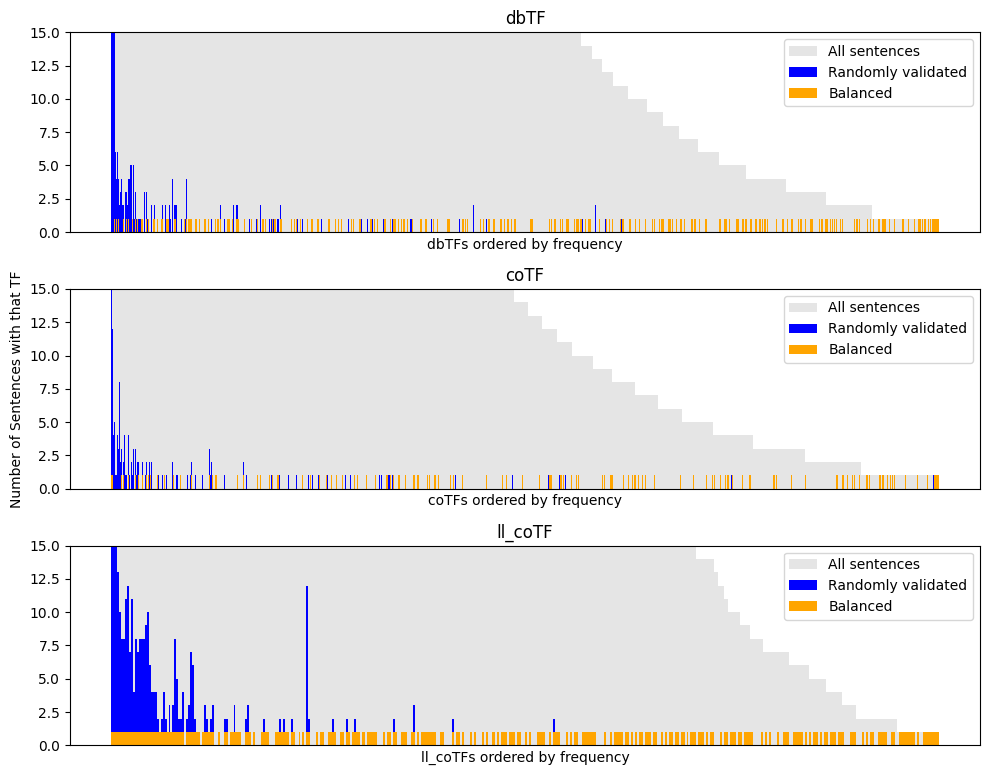

In [243]:
# PLOT - Ensure correctly balanced validation dataset
def plot_tf_validation_distribution(ax, tf_type: str, all_sents: pd.DataFrame, val_random: pd.DataFrame, val_balanced: pd.DataFrame, ylim=30):
    for df, label, color, alpha in [
        (all_sents, "All sentences", "grey", 0.2),
        (val_random, "Randomly validated", "blue", 1),
        (val_balanced, 'Balanced', "orange", 1)
    ]:
        counts = df['TF Id'].value_counts()
        ax.bar(counts.index, counts, label=label, color=color, alpha=alpha, width=1)
    ax.set_title(tf_type)
    ax.set_xticks([])
    #plt.xticks(rotation='vertical')
    ax.set_xlabel(f"{tf_type}s ordered by frequency")
    ax.set_ylim((0,ylim))
    ax.legend()

def plot_all_tf_validation_distributions(title, ExTRI2_df, validated_1mapping, figsize=(15, 10), ylim=30):

    fig, axes = plt.subplots(3, 1, figsize=figsize)
    for i, TF_type in enumerate(['dbTF', 'coTF', 'll_coTF']):
        TRI_subset = ExTRI2_df[ExTRI2_df['TF_type'] == TF_type]
        validated_subset = validated_1mapping[(validated_1mapping['TF_type_validated'] == TF_type)]

        validated_subset_b = validated_subset[validated_subset['method'] == 'balanced']
        validated_subset_r = validated_subset[validated_subset['method'] == 'random']

        plot_tf_validation_distribution(axes[i], TF_type, TRI_subset, val_balanced = validated_subset_b, val_random = validated_subset_r, ylim=ylim)
    axes[1].set_ylabel(f"Number of Sentences with that TF")



    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

title = "Distribution of the TFs for the random and balanced datasets for the three TF types"
plot_all_tf_validation_distributions('', ExTRI2_df, validated_df[(validated_df['pre-post'] == 'pre') & (validated_df['Label'] == 'TRUE')], figsize=(10, 8), ylim = 15)

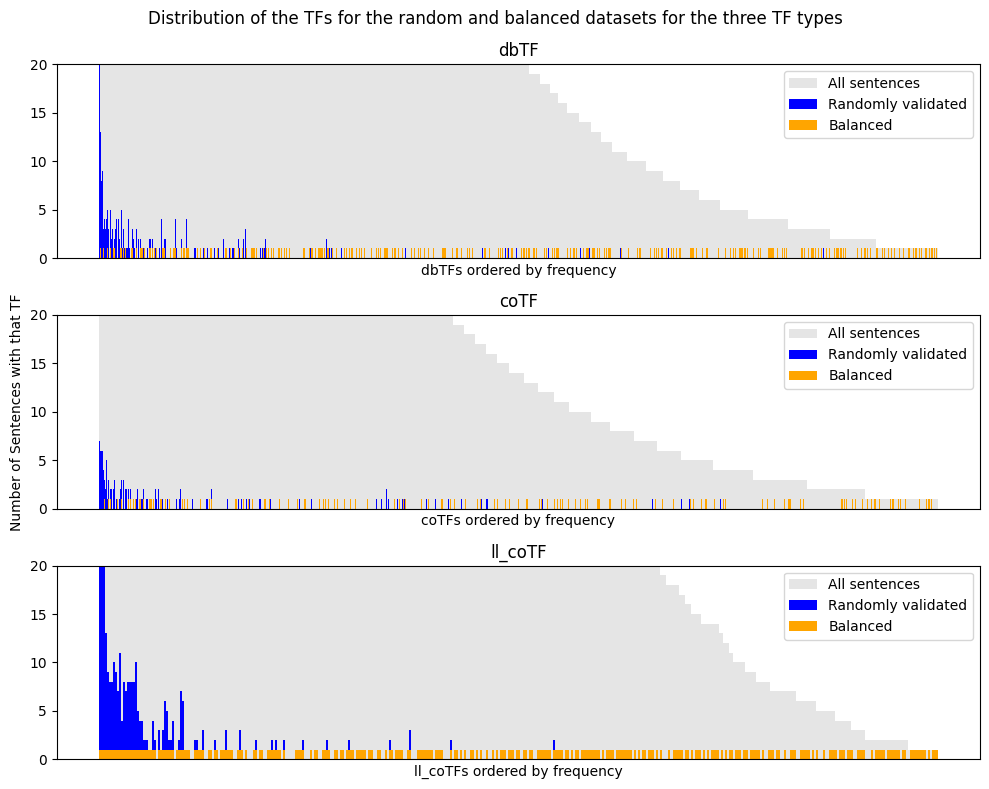

In [244]:
plot_all_tf_validation_distributions(title, ExTRI2_df, validated_df[(validated_df['pre-post'] == 'post') & (validated_df['Label'] == 'TRUE')], figsize=(10, 8), ylim = 20)

In [245]:
def evaluate_other_issues(validated_df):
    h3("Other issues")

    # Get sentences where there are other issues
    o_i = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first').dropna(subset=['Other issues'])

    # Display common issues
    display(o_i['Other issues'].apply(lambda x: x.split(';')).explode().value_counts())

    # Get uniquely validated sentences
    validated_unique = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first')

    # Splitter / suboptimal / dir-gene issues
    m = validated_unique['Other issues'].fillna('').str.contains('Splitter')
    print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences are incorrecty splitted")
    m = validated_unique['Other issues'].fillna('').str.contains('suboptimal')
    print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences are suboptimal")
    m = validated_unique['dir-*'].fillna('') == 'dir-gene'
    print(f"{m.sum()}/{len(m)} ({m.sum()/len(m):.1%}) sentences classified as 'dir-gene")

    # Check for more common issues, what proportion of the dataset do they appear in
    results = []
    for tf_type in ['dbTF', 'coTF', 'll_coTF']:
        for method in ['random', 'balanced']:
            for p in ['pre', 'post']:
                for validity in ['T', 'F']:

                    df = validated_df[(validated_df['TF_type_validated'] == tf_type) & (validated_df['method'] == method) & (validated_df['pre-post'] == p) & (validated_df['Label'] == 'TRUE') & (validated_df['Valid?'] == validity)]
                    
                    r = {
                        'tf_type': tf_type,
                        'Valid?': validity,
                        'method': method,
                        'pre-post': p,
                        'num_sents': str(len(df))
                    }

                    for issue in ['mutation', 'PPI', 'negation']:
                        m = df['Other issues'].fillna('').str.contains(issue)
                        r[issue] = len(df[m]) / len(df) if m.sum() > 0 else 0
            
                    results.append(r)
    
    index_cols = ['tf_type', 'Valid?', 'method', 'pre-post']
    return pd.DataFrame(results).sort_values(by=index_cols).set_index(index_cols)
  
def display_o_i_joined_pre_post(o_i_results):

    index = ['tf_type', 'Valid?', 'method']
    # Pivot pre-post from row index to column index
    o_i_pivot = o_i_results.reset_index().pivot_table(
        index=index,
        columns='pre-post',
        values=['num_sents', 'mutation', 'PPI', 'negation'],
        aggfunc= lambda x: x#f"{x:.2%}" if isinstance(x, float) else str(x)
    )

    # Convert all values to strings for easier handling
    for col in ['mutation', 'PPI', 'negation']:
        o_i_pivot[col] = o_i_pivot[col].map(lambda x: f"{x:.1%}" if isinstance(x, (float)) else str(x))

    # Combine pre and post columns for each metric
    for col in ['mutation', 'PPI', 'negation', 'num_sents']:
        o_i_pivot[(col, 'pre-post')] = (
            o_i_pivot[(col, 'pre')].astype(str) + ' - ' + o_i_pivot[(col, 'post')].astype(str)
        )

    # Filter unnecessary columns
    o_i_pivot = o_i_pivot.filter(like='pre-post')

    # Drop pre-post level
    o_i_pivot.columns = o_i_pivot.columns.droplevel(level=1)

    # Sort tf_type in the order: dbTF, coTF, ll_coTF
    o_i_pivot = o_i_pivot.reset_index()
    o_i_pivot['tf_type'] = pd.Categorical(
        o_i_pivot['tf_type'], categories=['dbTF', 'coTF', 'll_coTF'], ordered=True
    )
    o_i_pivot = o_i_pivot.sort_values(by=index).set_index(index)


    h3('Other issues, pre-post')
    display(o_i_pivot)

o_i_results = evaluate_other_issues(validated_df)
display_o_i_joined_pre_post(o_i_results)

<h3>Other issues</h3>

Other issues
mutation      802
PPI           367
Splitter       54
negation       37
suboptimal      6
Name: count, dtype: int64

54/3999 (1.4%) sentences are incorrecty splitted
6/3999 (0.2%) sentences are suboptimal
3/3999 (0.1%) sentences classified as 'dir-gene


<h3>Other issues, pre-post</h3>

mutation            PPI     negation  num_sents
tf_type Valid? method                                                        
dbTF    F      balanced    4.7% - 8.2%  22.5% - 22.1%  0.6% - 0.8%  169 - 122
               random    18.3% - 18.8%    6.3% - 5.5%  2.1% - 2.3%  142 - 128
        T      balanced  22.9% - 21.2%    0.0% - 0.0%  1.0% - 0.7%  700 - 737
               random    31.2% - 31.1%    0.0% - 0.0%  1.6% - 1.6%  764 - 759
coTF    F      balanced    2.8% - 3.3%  51.1% - 55.6%  0.0% - 0.7%  180 - 153
               random      5.1% - 6.3%  52.8% - 62.9%  0.5% - 0.6%  195 - 159
        T      balanced  42.0% - 44.6%    0.0% - 0.0%  0.4% - 1.1%  264 - 276
               random    46.0% - 45.9%    0.0% - 0.0%  0.6% - 0.7%  313 - 303
ll_coTF F      balanced    0.8% - 0.8%  39.2% - 47.1%  0.0% - 0.8%  120 - 121
               random      1.5% - 1.8%  37.4% - 44.2%  0.0% - 0.0%  198 - 163
        T      balanced  30.7% - 27.4%    0.0% - 0.0%  1.3% - 1.2%  150 - 164
               random    32.1% - 31.8%    0.0% - 0.0%  2.1% - 2.1%  237 - 233

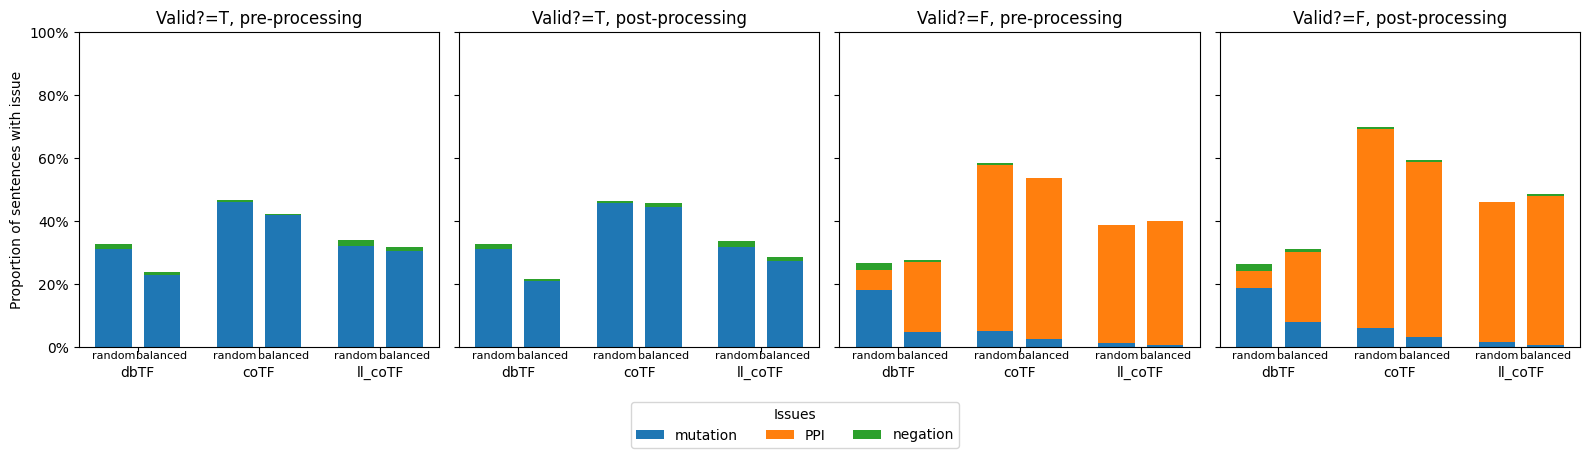

In [246]:
def plot_other_issues_by_combination(o_i_results, figsize=(14, 4)):
    # Reset the index to use the index columns as regular columns
    o_i_results_reset = o_i_results.reset_index()

    # Define issues and tf_types
    issues = ['mutation', 'PPI', 'negation']
    tf_types = ['dbTF', 'coTF', 'll_coTF']
    hue = 'method'  # Random/Balanced will be the hue
    hue_levels = ['random', 'balanced']  # Ensure this order
    bar_width = 0.2
    group_width = bar_width * len(hue_levels) + 0.1
    withingroup_space = 0.05

    # Define combinations of Valid? and pre-post
    combinations = [
        {'Valid?': 'T', 'pre-post': 'pre'},
        {'Valid?': 'T', 'pre-post': 'post'},
        {'Valid?': 'F', 'pre-post': 'pre'},
        {'Valid?': 'F', 'pre-post': 'post'},
    ]

    # Create a plot for each combination
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=True)
    # axes = axes.flatten()

    for i, (ax, combination) in enumerate(zip(axes, combinations)):
        # Filter data for the current combination
        filtered = o_i_results_reset[
            (o_i_results_reset['Valid?'] == combination['Valid?']) &
            (o_i_results_reset['pre-post'] == combination['pre-post'])
        ]

        # Group data by tf_type and method
        grouped = filtered.groupby(['tf_type', hue])[issues].mean().reset_index()

        # Ensure tf_types and hue levels are consistent
        grouped['tf_type'] = pd.Categorical(grouped['tf_type'], categories=tf_types, ordered=True)
        grouped[hue] = pd.Categorical(grouped[hue], categories=hue_levels, ordered=True)
        grouped = grouped.sort_values(['tf_type', hue])

        # Set bar positions
        x = np.arange(len(tf_types)) * group_width

        # Plot stacked bars for each hue level
        for j, level in enumerate(hue_levels):
            level_data = grouped[grouped[hue] == level]

            # Initialize bottom values
            bottom = np.zeros(len(tf_types))

            # Plot each issue as a stacked segment
            for k, issue in enumerate(issues):
                ax.bar(
                    x + j * bar_width,  # Offset bars within the group
                    level_data[issue],
                    width=bar_width - withingroup_space,
                    bottom=bottom,
                    label=issue if j == 0 else "",
                    color=f'C{k}'
                )
                bottom += level_data[issue]

        # Add TF type labels below the bars
        ax.set_xticks(x + (bar_width * len(hue_levels) / 2) - bar_width / 2)
        ax.set_xticklabels(['' for _ in tf_types])  # Temporarily blank x-ticks

        # ax.set_xticklabels(tf_types)
        ax.set_title(f"Valid?={combination['Valid?']}, {combination['pre-post']}-processing")

        # # Add individual hue labels below each bar and move TF type labels further down
        ax.set_xticks(x + (bar_width * len(hue_levels) / 2) - bar_width / 2)  # Center the group


        # Add individual bar labels for the method
        for j, level in enumerate(hue_levels):
            for idx, tf_type in enumerate(tf_types):
                ax.text(
                    x[idx] + j * bar_width,  # Position based on the bar
                    -0.01,  # Move further down
                    f"{level}", ha="center", va="top", fontsize=8, rotation=0
                )

        # Add TF type labels below the hue labels
        for idx, tf_type in enumerate(tf_types):
            ax.text(
                x[idx] + (bar_width * (len(hue_levels) - 1) / 2),  # Center the label below the group
                -0.06,  # Move further down
                f"{tf_type}", ha="center", va="top", fontsize=10,
            )

        # Format the axes
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

        if i == 0:
            ax.set_ylabel('Proportion of sentences with issue')

    # Add a single legend
    fig.legend(
        labels=issues, loc='lower center', ncol=len(issues), title="Issues",
        bbox_to_anchor=(0.5, -0.15), fontsize=10
    )

    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_other_issues_by_combination(o_i_results)

In [247]:
# TODO - Show Astrid plot & ask about 'unexpected' observations

**Observations:**<br>
Expected:
* PPI is only observed in invalid sentences
* PPI is way more common in coTF than in dbTF → coTF tends to form PPIs more frequently

Unexplained:
* PPI is way more common in balanced than random dataset → PPIs for more uncommon TFs are not detected (results dependant on the TF frequency ??)
* Negation is too uncommon to say anything relevant about it

Unexpected:
* PPI occurs more on coTF than on ll-coTF → would expect the opposite
* Mutation is way more common in random than balanced datasets → less checked for in balanced? Less detected (and thus false?)

In [301]:
# RESULTS
def TRI_validation_results_table(validated_df):
    '''Make table with validation results. Only include TRUE labels'''

    # Only consider TRUE labels
    validated_df_true = validated_df[validated_df['Label'] == 'TRUE']

    results = []
    for tf_type in ['dbTF', 'coTF', 'll_coTF']:
        for method in ['random', 'balanced']:
            for p in ['pre', 'post']:
                df = validated_df_true[(validated_df_true['TF_type_validated'] == tf_type) & (validated_df_true['method'] == method) & (validated_df_true['pre-post'] == p)]
                
                r = {
                    'tf_type': tf_type,
                    'method': method,
                    'validation stage': p,
                    'num_sents': len(df)
                }

                # Get number of sentences with correct TRIs
                m_T_TRI_df = df['true_label'] == 'TRUE'
                r['Num correct TRIs'] = m_T_TRI_df.sum()

                # Get NER & norm stats
                r['NER'] = 1 - sum(((df[f'{T}_is_incorrect'].str.contains('NER')).sum() for T in ['TF', 'TG'])) / r['num_sents']
                r['NER-TF'] = 1 - (df[f'TF_is_incorrect'].str.contains('NER')).sum() / r['num_sents']
                r['NER-TG'] = 1 - (df[f'TG_is_incorrect'].str.contains('NER')).sum() / r['num_sents']

                r['norm'] = 1 - sum(((df[f'{T}_is_incorrect'].str.contains('norm')).sum() for T in ['TF', 'TG'])) / r['num_sents']
                r['norm-TF'] = 1 - (df[f'TF_is_incorrect'].str.contains('norm')).sum() / r['num_sents']
                r['norm-TG'] = 1 - (df[f'TG_is_incorrect'].str.contains('norm')).sum() / r['num_sents']

                # Get TRI stats
                r['TRI'] = 1 - (df['Label'] != df['true_label']).sum() / r['num_sents']

                # Get MoR stats - over those whose true_label is True
                # TODO - I should show the num_TRIs somewhere, & explain how the calculation was done. Maybe show num_TRIs?
                MoR_df = df[m_T_TRI_df]
                r['MoR'] = len(MoR_df[(MoR_df['MoR'] == MoR_df['true_MoR'])]) / len(MoR_df)
                for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']:
                    r[MoR.capitalize()] = len(MoR_df[(MoR_df['MoR'] == MoR) & (MoR_df['MoR'] == MoR_df['true_MoR'])]) / len(MoR_df[(MoR_df['MoR'] == MoR)])

                # num_TRIs = (df['true_label'] == 'TRUE').sum()
                # r['MoR'] = 1 - len(df[(df['MoR'] != df['true_MoR']) & ~df['MoR'].isna()]) / num_TRIs
                # for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']:
                #     r[MoR] = 1 - len(df[(df['MoR'] == MoR) & (df['MoR'] != df['true_MoR'])]) / num_TRIs


                # Get final probability                
                r['Overall']  = ((df['Valid?'] == 'T') & df[f'TF_is_incorrect'].isna() & df[f'TG_is_incorrect'].isna() ).sum() / r['num_sents']

                # Ensure num_sents is not treated as a float in the printed table
                r['num_sents'] = str(r['num_sents'])
                r['Num correct TRIs'] = str(r['Num correct TRIs'])

                results.append(r)
   

    return pd.DataFrame(results).set_index(['tf_type', 'method', 'validation stage']).T

def nonTRI_validation_results_table(validated_df):
    '''Make table with validation results. Only include TRUE labels'''

    # Only consider TRUE labels
    # validated_df = validated_df[validated_df['Label'] == 'FALSE']
    validated_df = validated_df[(validated_df['method'] == 'random') & (validated_df['pre-post'] == 'post')]

    results = []
    for tf_type in ['dbTF', 'coTF', 'll_coTF']:
        df = validated_df[(validated_df['TF_type_validated'] == tf_type)]
        
        r = {'tf_type': tf_type}

        for label, state in (['TRUE', 'TRI'], ['FALSE', 'not TRI']):
            total_num = len(df[df['Label'] == label])
            num_valid = len(df[(df['Label'] == label) & (df['Label'] == df['true_label'])])

            r[state] = f"{num_valid}/{total_num} ({num_valid / total_num:.2%})"

        results.append(r)
   

    return pd.DataFrame(results).set_index(['tf_type']).T

def show_general_statistics(validated_df):
    validated_unique = validated_df.drop_duplicates(subset=['#SentenceID'], keep='first')

    r = {}
    r['Total'] = len(validated_unique['#SentenceID'].unique())
    for TF in ['dbTF', 'coTF', 'll_coTF']:
        r[TF] = len(validated_unique[validated_unique['TF_type_validated'] == TF])
    
    display(pd.DataFrame.from_dict(r, orient='index', columns=['Number of sentences']))

    return

show_general_statistics(validated_df)

pd.set_option("display.float_format", "{:.1%}".format)

for results_table_f in (TRI_validation_results_table, nonTRI_validation_results_table):
    results_table = results_table_f(validated_df)
    h3(results_table_f.__name__)
    display(results_table)
    results_table.to_csv(f'tables/{results_table_f.__name__}.tsv', sep='\t')

,Number of sentences
Total,3999
dbTF,2084
coTF,1174
ll_coTF,741


<h3>TRI_validation_results_table</h3>

tf_type            dbTF                        coTF                      ll_coTF                       
method           random       balanced       random       balanced        random        balanced       
validation stage    pre  post      pre  post    pre  post      pre  post     pre   post      pre   post
num_sents           906   887      869   859    508   462      444   429     435    396      270    285
Num correct TRIs    840   832      729   769    325   315      274   286     245    241      153    169
NER               98.3% 98.6%    97.5% 98.4%  97.8% 98.1%    97.7% 97.0%   97.7%  99.7%    98.5%  97.9%
NER-TF            99.1% 99.4%    97.7% 98.7%  98.0% 98.3%    98.0% 97.7%   97.7%  99.7%    98.9%  98.6%
NER-TG            99.2% 99.2%    99.8% 99.7%  99.8% 99.8%    99.8% 99.3%  100.0% 100.0%    99.6%  99.3%
norm              95.0% 96.1%    95.2% 96.2%  96.3% 97.0%    95.7% 95.1%   96.3%  98.7%    94.8%  95.4%
norm-TF           98.8% 99.0%    96.7% 97.4%  98.0% 98.3%    96.6% 96.0%   96.8%  99.2%    96.7%  96.8%
norm-TG           96.2% 97.1%    98.5% 98.7%  98.2% 98.7%    99.1% 99.1%   99.5%  99.5%    98.1%  98.6%
TRI               92.7% 93.8%    83.9% 89.5%  64.0% 68.2%    61.7% 66.7%   56.3%  60.9%    56.7%  59.3%
MoR               91.0% 91.2%    96.0% 95.8%  96.3% 96.2%    96.4% 96.5%   96.7%  96.7%    98.0%  97.0%
Activation        92.4% 92.6%    97.7% 97.3%  96.6% 96.5%    95.9% 95.0%   97.0%  97.0%    98.9%  99.0%
Repression        83.8% 84.6%    90.7% 91.1%  94.2% 94.0%    96.2% 97.4%   94.4%  94.4%    94.3%  91.1%
Undefined         94.0% 94.0%    98.3% 97.9%  98.6% 98.6%    97.2% 98.6%  100.0% 100.0%   100.0% 100.0%
Overall           79.7% 81.8%    77.3% 83.6%  59.6% 64.1%    58.1% 63.2%   53.6%  58.3%    53.7%  55.4%

<h3>nonTRI_validation_results_table</h3>

tf_type,dbTF,coTF,ll_coTF
TRI,832/887 (93.80%),315/462 (68.18%),241/396 (60.86%)
not TRI,289/291 (99.31%),169/169 (100.00%),98/98 (100.00%)


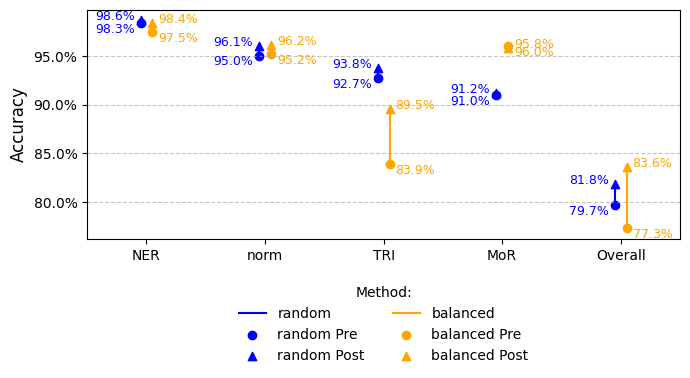

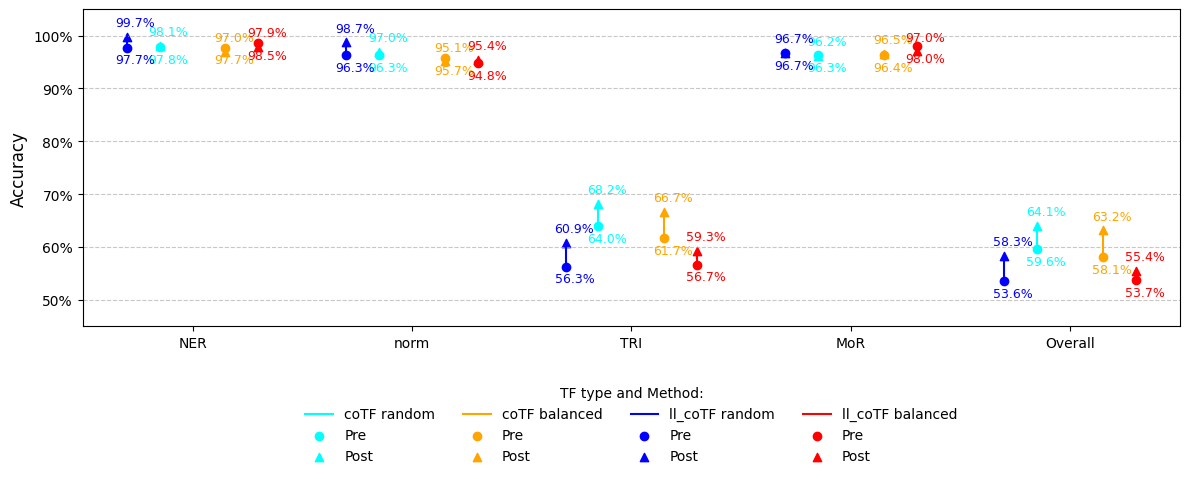

In [299]:
def make_validation_dotplot(results_table, TF_type = 'dbTF', y_sep = 0):

    XXTF_results_table = results_table[results_table['tf_type'] == TF_type]

    # Create the improved dot plot
    fig, ax = plt.subplots(figsize=(7, 4))

    cols = ['NER', 'norm', 'TRI', 'MoR', 'Overall']
    for i, col in enumerate(cols):

        # Add vertical lines for random and balanced
        for method, sep, color, orientation in [('random', -0.05, 'blue', 'right'), ('balanced', 0.05, 'orange', 'left')]: 

            # Get values for random and balanced for pre and post
            values = {}
            for pre_post in ['pre', 'post']:
                values[pre_post] = XXTF_results_table[(XXTF_results_table['method'] == method) & (XXTF_results_table['pre-post'] == pre_post)][col].values[0]

            ax.plot([i + sep, i + sep], [values['pre'], values['post']], color=color, label=method if i == 0 else "")
            ax.scatter([i + sep], [values['pre']], color=color, marker='o', label=f'{method} Pre' if i == 0 else "")
            ax.scatter([i + sep], [values['post']], color=color, marker='^', label=f'{method} Post' if i == 0 else "")

            # Add value labels next to the dots
            ax.text(i + sep*2, values['pre']-0.01-y_sep, f"{values['pre']:.1%}", fontsize=9, color=color, ha=orientation)
            ax.text(i + sep*2, values['post']+y_sep, f"{values['post']:.1%}", fontsize=9, color=color, ha=orientation)

    # Customize plot appearance
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_xlim(-0.5, len(cols) - 0.5)
    # ax.set_ylim(0.7, 1.0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # ax.set_title('Pre- and Post-Processing Accuracy: Random vs Balanced Sampling', fontsize=14)
    ax.legend(title='Method:', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10, frameon=False)

    # Add gridlines for readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def make_coTF_validation_dotplot(results_table, y_sep = 0.03):

    # Create the improved dot plot
    fig, ax = plt.subplots(figsize=(12, 5))

    cols = ['NER','norm',  'TRI', 'MoR', 'Overall']

    for TF_type, x_sep in [('coTF', 0.15), ('ll_coTF', 0.3)]:

        XXTF_results_table = results_table[results_table['tf_type'] == TF_type]

        for i, col in enumerate(cols):

            # Add vertical lines for random and balanced
            for method, sep, orientation in [('random', -x_sep, 'right'), ('balanced', x_sep, 'left')]: 

                if TF_type == 'coTF':
                    color = 'aqua' if method == 'random' else 'orange'
                else:
                    color = 'blue' if method == 'random' else 'red'

                # Get values for random and balanced for pre and post
                values = {}
                for pre_post in ['pre', 'post']:
                    values[pre_post] = XXTF_results_table[(XXTF_results_table['method'] == method) & (XXTF_results_table['pre-post'] == pre_post)][col].values[0]

                ax.plot([i + sep, i + sep], [values['pre'], values['post']], color=color, label=f"{TF_type} {method}" if i == 0 else "")
                ax.scatter([i + sep], [values['pre']], color=color, marker='o', label=f'Pre' if i == 0 else "")
                ax.scatter([i + sep], [values['post']], color=color, marker='^', label=f'Post' if i == 0 else "")

                # Add value labels next to the dots
                ax.text(i + sep-0.05, values['pre']  - y_sep, f"{values['pre']:.1%}", fontsize=9, color=color)
                ax.text(i + sep-0.05, values['post'] + y_sep-0.01, f"{values['post']:.1%}", fontsize=9, color=color)

    # Customize plot appearance
    ax.set_xticks(range(len(cols)))
    ax.set_xticklabels(cols)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_xlim(-0.5, len(cols) - 0.5)
    ax.set_ylim(0.45, 1.05)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    # ax.set_title('Pre- and Post-Processing Accuracy: Random vs Balanced Sampling', fontsize=14)
    ax.legend(title='TF type and Method:', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4, fontsize=10, frameon=False)

    # Add gridlines for readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


TRI_results_table = TRI_validation_results_table(validated_df).T.reset_index()
make_validation_dotplot(TRI_results_table)
make_coTF_validation_dotplot(TRI_results_table)

# make_validation_dotplot(results_table, 'coTF', y_sep=0.01)
# make_validation_dotplot(results_table, 'll_coTF', y_sep=0.01)

COMMENT:
* MoR remains largely unaffected by whether it is pre, post, random or not random. It is constant.
* TRI, however, is more affected. Specially for dbTF, we see a drop of 10% in the accuracy of the model when calculating balanced datasets. A trend that is not observable in coTF. This shows that our model has been trained to somewhat learn the most popular TFs
* However, for coTF it doesn't change much, as it hasn't been trained on coTFs, proving even more that it has learned about the dbTFs to consider as positives. The model is therefore better at recalling more popular TFs than those that it hasn't seen on the training set.
* For the balanced, there is a big leap between pre- and post-, which I should try to find a way to understand
* NER and norm do not see much change between conditions: they're good independently of the frequency

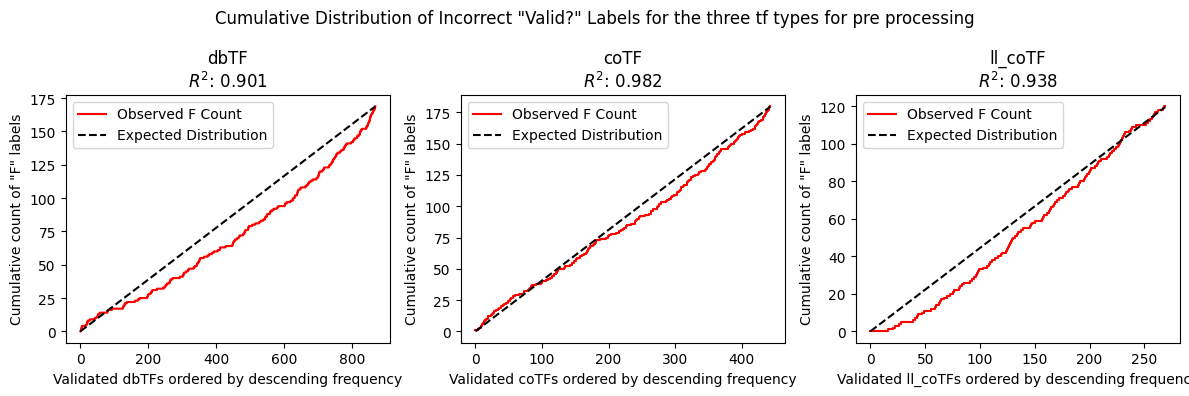

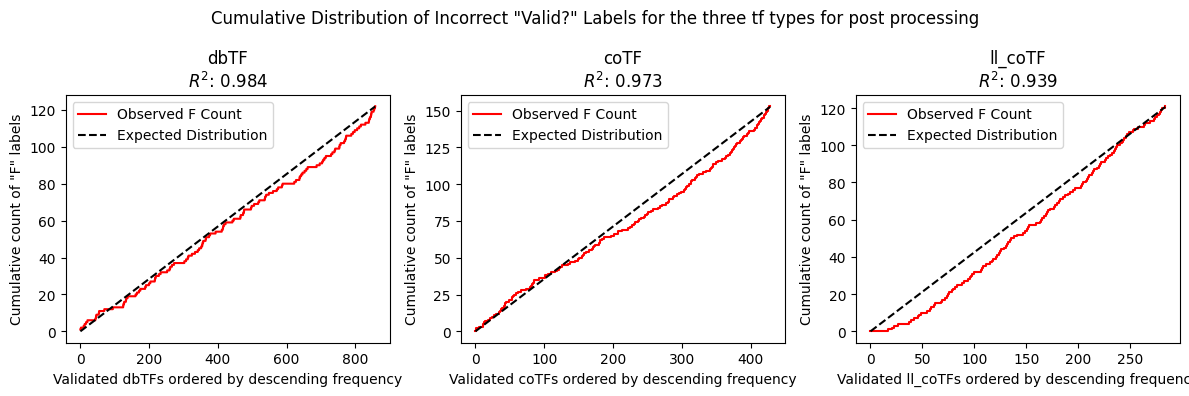

In [273]:
from sklearn.metrics import r2_score

def plot_false_validation_distribution(ExTRI2_df: pd.DataFrame, val_df: pd.DataFrame, pre_post: str):

    # Initialise plot
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
    plt.suptitle(f'Cumulative Distribution of Incorrect "Valid?" Labels for the three tf types for {pre_post} processing')


    for i, tf_type in enumerate(['dbTF', 'coTF', 'll_coTF']):

        # Get the subset of all sentences
        all_sents = ExTRI2_df[ExTRI2_df['TF_type'] == tf_type]

        # Get the subset of balanced TF_type sentences (post-processing)
        val_balanced = val_df[(val_df['TF_type'] == tf_type) & (val_df['method'] == 'balanced') & (val_df['pre-post'] == pre_post)].copy()

        # Count frequency of TF Ids in all_sents
        tf_frequencies = all_sents['TF Id'].value_counts()

        # Order the val_balanced dataset by TF frequency
        val_balanced['TF_frequency'] = val_balanced['TF Id'].map(tf_frequencies)
        val_balanced = val_balanced.sort_values(by='TF_frequency', ascending=False)

        # Add a column for the 'F' binary values (1 if Valid?=F, otherwise 0)
        val_balanced['Is_F'] = (val_balanced['Valid?'] == 'F').astype(int)

        # Compute cumulative sum of 'Is_F' for plotting
        val_balanced['Cumulative_F'] = val_balanced['Is_F'].cumsum()

        # Step 5: Plot the cumulative sum of 'F's
        ax = axes[i]
        ax.step(range(len(val_balanced)), val_balanced['Cumulative_F'], where='mid', label='Observed F Count', color='red')
        

        # Step 6: Plot the expected line
        total_f_count = val_balanced['Is_F'].sum()
        val_balanced['Expected_F'] = [total_f_count * (i / len(val_balanced)) for i in range(len(val_balanced))]
        ax.plot(range(len(val_balanced)), val_balanced['Expected_F'], label='Expected Distribution', linestyle='--', color='black')

        # Calculate R^2
        r2 = r2_score(val_balanced['Expected_F'], val_balanced['Cumulative_F'])

        # Customize plot
        ax.set_title(f"{tf_type}\n$R^2$: {r2:.3f}")
        ax.set_xlabel(f'Validated {tf_type}s ordered by descending frequency')
        ax.set_ylabel('Cumulative count of "F" labels')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_false_validation_distribution(ExTRI2_df, validated_df, 'pre')
plot_false_validation_distribution(ExTRI2_df, validated_df, 'post')

What is seen here is that unvalid sentences are more concentrated towards the end, but not by much. However, this is observed in dbTF, coTF and ll_coTF, while we might have expected dbTF to be the one that shows it more pronunciately

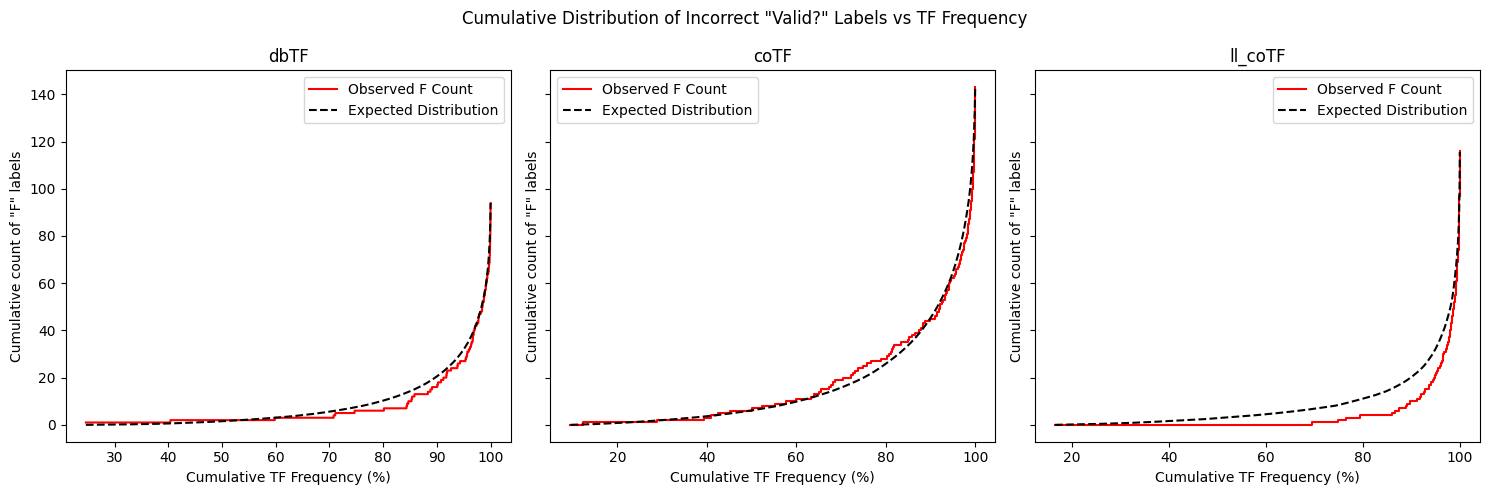

In [253]:
def plot_notTRI_validation_distribution_frequency(ExTRI2_df: pd.DataFrame, val_df: pd.DataFrame):
    # Initialise plot
    fig, axes = plt.subplots(ncols=3, figsize=(15, 5), sharey=True)
    plt.suptitle('Cumulative Distribution of Incorrect "Valid?" Labels vs TF Frequency')

    for i, tf_type in enumerate(['dbTF', 'coTF', 'll_coTF']):
        # Get the subset of all sentences
        all_sents = ExTRI2_df[ExTRI2_df['TF_type'] == tf_type]

        # Get the subset of balanced TF_type sentences (post-processing)
        val_balanced = val_df[(val_df['TF_type'] == tf_type) & (val_df['method'] == 'balanced') & (val_df['pre-post'] == 'post')].copy()

        # Count frequency of TF Ids in all_sents
        tf_frequencies = all_sents['TF Id'].value_counts()

        # Add TF frequency to the val_balanced dataset and sort by frequency
        val_balanced['TF_frequency'] = val_balanced['TF Id'].map(tf_frequencies)
        val_balanced = val_balanced.sort_values(by='TF_frequency', ascending=False)

        # Add a column for the 'F' binary values (1 if Valid?=F, otherwise 0)
        val_balanced['Is_F'] = (val_balanced['Label'] != val_balanced['true_label']).astype(int)

        # Compute cumulative sum of 'Is_F'
        val_balanced['Cumulative_F'] = val_balanced['Is_F'].cumsum()

        # Compute cumulative TF frequency
        val_balanced['Cumulative_Frequency'] = val_balanced['TF_frequency'].cumsum()

        # Normalize cumulative frequency to represent percentages
        val_balanced['Cumulative_Frequency_Percent'] = val_balanced['Cumulative_Frequency'] / val_balanced['TF_frequency'].sum() * 100

        # Step 5: Plot cumulative F labels against cumulative frequency percentage
        ax = axes[i]
        ax.step(val_balanced['Cumulative_Frequency_Percent'], val_balanced['Cumulative_F'], where='mid', label='Observed F Count', color='red')

        # Step 6: Plot the expected line
        total_f_count = val_balanced['Is_F'].sum()
        ax.plot(
            val_balanced['Cumulative_Frequency_Percent'], 
            [total_f_count * (i / len(val_balanced)) for i in range(len(val_balanced))],
            label='Expected Distribution', linestyle='--', color='black'
        )

        # Customize plot
        ax.set_title(tf_type)
        ax.set_xlabel('Cumulative TF Frequency (%)')
        ax.set_ylabel('Cumulative count of "F" labels')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_notTRI_validation_distribution_frequency(ExTRI2_df, validated_df)

### MUST CORRECT

In [255]:
# DIFFERENT TODOs

# TODO - If I show Astrid, put it in a more appropriate folder

# TODO - Astrid considered "Negation" as positive. I should change this in validation. (haven't I already? Check)
# TODO - Check if 'Negation' is considered as positive or negative
m = validated_df['Other issues'].str.contains('negation')


# TODO - Talk with Astrid on what to do with those sentences
# TODO - Add also the ones obtained from the iterations on the NTNU dataset. 
#        & save them somewhere
# Number of PPI sentences: 
validated_df['Other issues'].fillna('', inplace=True)
m = validated_df['Other issues'].str.contains('PPI')
validated_df[m]['TF_type_validated'].value_counts()

TF_type_validated
coTF       380
ll_coTF    250
dbTF        81
Name: count, dtype: int64

## 3.2. Curated Dataset for Training - The NTNU collection

See [update_tri_sentences.ipynb](../scripts/classifiers_training/updated_tri_sentences.ipynb) for details on how the final_NTNU_df was created



In [7]:
original_NTNU_df = pd.read_csv('../data/external/original_tri_sentences.tsv', sep='\t', skiprows=1)
final_NTNU_df = pd.read_csv('../classifiers_training/data/tri_sentences.tsv', sep='\t')

def display_NTNU_analysis():
    NTNU_analysis = {'Original': {}, 'Final': {}}

    for name, df in [('Original', original_NTNU_df), ('Final', final_NTNU_df)]: 
        NTNU_analysis[name]['Total'] = len(df)
        NTNU_analysis[name]['Unique'] = len(df[['Sentence', 'TF', 'TG']].drop_duplicates())
        NTNU_analysis[name]['Duplicated'] = (df[['Sentence', 'TF', 'TG']].duplicated().sum())


        for TRI in [False, True]:
            NTNU_analysis[name][TRI] = len(df[df['Label'] == TRI])
        for MoR in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
            NTNU_analysis[name][MoR] = len(df[df['Type'] == MoR])
            
    NTNU_analysis = pd.DataFrame.from_dict(NTNU_analysis)
    NTNU_analysis['difference'] = NTNU_analysis['Final'] - NTNU_analysis['Original']

    display(NTNU_analysis.map(lambda x: f"{x:,}" if isinstance(x, int) else x))

display_NTNU_analysis()

,Original,Final,difference
Total,"22,135","21,651",-484
Unique,"21,766","21,651",-115
Duplicated,369,0,-369
False,"10,986","10,272",-714
True,"11,149","11,379",230
UNDEFINED,"3,884","4,030",146
ACTIVATION,"5,339","5,331",-8
REPRESSION,"1,926","2,018",92


Differences between original and final:
* -234 (dropped as they're duplicated)
* -275 (dropped as they differ on their Label or MoR)
* +25 (added as negations)

25 - 234 - 275 = -484



## Other notebooks

### 3.1. Data Sources & Preparation

3.1.2. Retrieving TF Gene IDs - see [get_NCBI_TF_IDs.ipynb](../scripts/preprocessing/get_NCBI_TF_IDs.ipynb)

3.1.3. NTNU collection - see [make_train_data.ipynb](../scripts/classifiers_training/make_train_data.ipynb)

### 3.3. Classifiers dataset improvement
See [prepare_reannotation_Excels.ipynb](../scripts/classifiers_training/prepare_reannotation_Excels.ipynb) for the figures